In [7]:
import sys  
sys.path.insert(1, './../../../ESN-IP/IP/.')

import random

random.seed(10)

from DATA import InubushiFunction

data = InubushiFunction(ni=-1)
data.delay_timeseries(1)
data.split([80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()


In [8]:
import matplotlib.pyplot as plt

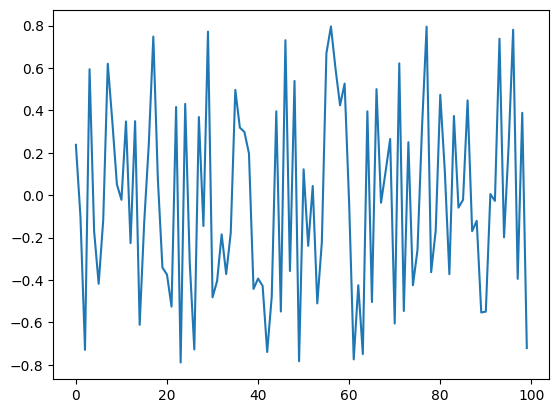

In [9]:
data.X_FULL.shape

plt.plot(data.X_TS[0:100])

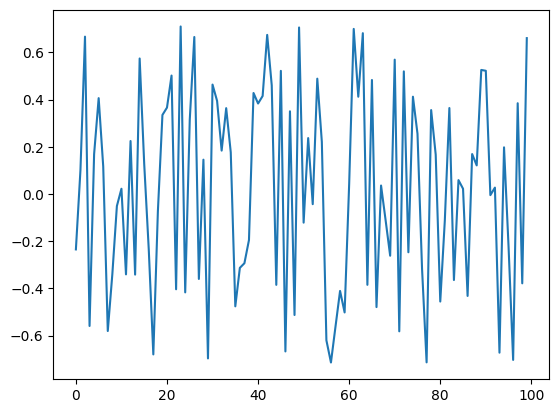

In [10]:
plt.plot(data.Y_TS[0:100])

In [11]:
from Metrics import MSE
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask, IPDistribution

N_UNITS_LIST = [100, 150, 200, 250]
W_range=(-0.5, 0.5)
initial_rho = 0.5
desired_rhos = [0.95, 0.95, 0.95, 0.95]
bias_range = [-0.1, 0.1]

In [12]:
REPETITIONS = 5
max_epochs = 15 
columns = ["Name", "TYPE", "MSE", "MC", "Lambda max", "delta_phI", "KL", "Rho", "A-Norm", "B-Norm"]
models_num = len(N_UNITS_LIST)*len(desired_rhos)
rows = []

for N_UNITS, desired_rho in zip(N_UNITS_LIST, desired_rhos):
    config_string = f"{N_UNITS} UNIT - Spectral Radius: {desired_rho}"
    names = ["Vanilla", "Gauss 1", "Gauss 2", "Bimodal", "Trim 1", "Trim 2", "Trim 3"]
    identifiers = [ f"- {name} - {config_string} " for name in names]
    
    for R in range(REPETITIONS):
        vanilla_reservoir = Reservoir(N = N_UNITS, desired_rho = desired_rho, W_range=W_range, bias_range=bias_range)
        
        gaussian_reservoir_1 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.5, apply_activation=True))
        gaussian_reservoir_2 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.gaussian(N_UNITS, 0.25, apply_activation=True))

        bimodal_reservoir = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.bimodal(N_UNITS, 0.69, 0.92, apply_activation=True))
        
        trimodal_reservoir_1 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.15, 0.92, apply_activation=True))
        trimodal_reservoir_2 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 9/10, 0.25, 0.075, 0.72, apply_activation=False))
        trimodal_reservoir_3 = IPReservoir(N = N_UNITS, desired_rho=initial_rho, bias = True, W_range=W_range, bias_range=bias_range, mask=IPMask.trimodal(N_UNITS, 7/10, 0.25, 0.075, 0.72, apply_activation=False))

        print("Traning IP models")
        gaussian_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=True)
        gaussian_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)
        bimodal_reservoir.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, verbose=False)
        trimodal_reservoir_1.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000005, verbose=False)
        trimodal_reservoir_2.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)
        trimodal_reservoir_3.safe_mode_pre_train(X_TR, max_epochs=max_epochs, max_rho=desired_rho, eta=0.000001, verbose=False)

        models = [vanilla_reservoir, gaussian_reservoir_1, gaussian_reservoir_2, bimodal_reservoir, trimodal_reservoir_1, trimodal_reservoir_2, trimodal_reservoir_3]

        for model_index in range(len(models)): 
            model = models[model_index]

            esn = EchoStateNetwork(model)
            esn.train(X_TR,Y_TR, 0)

            mse = esn.evaluate(X_TS, Y_TS, metric=MSE()).item()
            
            mc = esn.MemoryCapacity().item()
            
            lambda_max = model.LCE(X_TS)

            de_phi = model.de_fi()

            KL = model.kl_value.item() if model_index != 0 else None
            a_norm = model.a.norm().item() if model_index != 0 else 1
            b_norm = model.b.norm().item() if model_index != 0 else 0

            # columns = ["________________Name____________________","TYPE", "MSE","MC","Lambda max","delta_phI","KL", "Rho", "A-Norm", "B-Norm"]
            rows.append([f"{R+1}) {identifiers[model_index]}" , model_index, mse, mc, lambda_max, de_phi, KL, model.rho().item(), a_norm, b_norm])
            print(rows[-1])

        
        


Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10396014899015427. | Spectral radius: 0.5513025522232056
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11436858028173447. | Spectral radius: 0.6015068888664246
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.13463684916496277. | Spectral radius: 0.6593878269195557
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.17267772555351257. | Spectral radius: 0.7799428701400757
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.2281682938337326. | Spectral radius: 1.1086112260818481
Too high spectral radius: 1.1086112260818481, rolling back to previous state!
- Epoch: 1) | KL Divergence value: 0.1611793339252472. | Spectral radius: 0.7292944192886353
Epoch: 5) - Safe mode traning - Learning Rate = 6.25e-06
- Epo

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.96312e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.02345e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0274e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.8686640714804525e-06, 10.395102500915527, -0.23587927, 0.05473200315190074, 0.20437024533748627, 0.9437524080276489, 15.809185028076172, 3.344372510910034]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.08957e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.59811e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.71865e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 2.1763887616543798e-06, 10.00775146484375, -0.6289569, 0.046180164749538205, 0.11576792597770691, 0.5843113660812378, 11.529023170471191, 2.21703839302063]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.6284e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.93736e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.9441e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['1) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 1.9122028334095376e-06, 8.62967300415039, -0.4846772, 0.08098698176950528, 0.10334039479494095, 0.9486594200134277, 19.795740127563477, 10.3649263381958]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.90056e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.57483e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.91249e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 1.970271625850728e-07, 10.239970207214355, -0.12180646, 0.04736295057038612, 0.07494501024484634, 0.9440721273422241, 18.9349365234375, 7.836309909820557]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.76729e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.64806e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.78904e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 1.4690654097648803e-05, 9.012683868408203, -0.21241097, 0.04361466402547223, 0.05654600262641907, 0.9490610957145691, 17.35739517211914, 7.897147178649902]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.55482e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.70587e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


['1) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 1.112860559260298e-07, 8.444400787353516, -0.060107883, 0.061271804136639046, 0.0569988377392292, 0.9472431540489197, 21.198671340942383, 10.876429557800293]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10095704346895218. | Spectral radius: 0.5498389005661011
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11039130389690399. | Spectral radius: 0.5975258350372314
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.13046585023403168. | Spectral radius: 0.645910918712616
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.17422983050346375. | Spectral radius: 0.7034446001052856
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.23989689350128174. | Spectral radius: 0.8270387053489685
Epoch: 5) - Safe mod

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.88172e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.89667e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.87335e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 4.3801696847367566e-07, 9.493785858154297, -0.60732406, 0.04667797806152552, 0.2660144865512848, 0.940893292427063, 18.403661727905273, 5.113008499145508]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 2.3406572324802255e-07, 9.8546724319458, -0.5985776, 0.15417296365491975, 0.09378886967897415, 0.5667256116867065, 11.312211036682129, 1.8990898132324219]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.04465e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.47486e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.54301e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 2.0417239738890203e-06, 8.04239559173584, -0.39208472, 0.11596806932099309, 0.09462454915046692, 0.9479727745056152, 18.850723266601562, 9.43036937713623]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.46414e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.04343e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.06982e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 9.816162673814688e-07, 9.520986557006836, -0.069515735, 0.2990791883447608, 0.08107917755842209, 0.9407210350036621, 17.279428482055664, 8.107930183410645]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 3.7236762295833614e-07, 10.37335205078125, -0.119707175, 0.7128806970904789, 0.05362827330827713, 0.944392740726471, 15.716044425964355, 6.8649468421936035]
Reservoir warmed up with the first 100 time steps
['2) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 5.791972412794166e-08, 8.64178466796875, -0.13312246, 0.05274381771625254, 0.05817251279950142, 0.9451352953910828, 21.63623046875, 11.296059608459473]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10417178273200989. | Spectral radius: 0.5514323711395264
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.114379703

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.0032e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.9775e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.99321e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['3) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.8955282712340704e-06, 9.222968101501465, -0.66664016, 0.05884927541052453, 0.26085540652275085, 0.9443377256393433, 18.38221549987793, 5.213339328765869]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.34381e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.00222e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.9099e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 2.832114489592641e-07, 10.5413818359375, -0.7493228, 0.10285465696607292, 0.08471059054136276, 0.5563877820968628, 11.202849388122559, 1.6730413436889648]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.77664e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.68125e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.68048e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 7.254336651385529e-07, 8.535737991333008, -1.3110623, 0.09554337453593288, 0.10031361132860184, 0.9424353241920471, 18.354415893554688, 9.034442901611328]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.03695e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.22069e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.2245e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 7.106067414497375e-07, 9.859108924865723, -0.081621625, 0.04635512758939013, 0.077416330575943, 0.9441816806793213, 16.952329635620117, 7.9257965087890625]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13483e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.13302e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.4865e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 3.4616337529769226e-07, 9.799243927001953, -0.0773426, 0.08779473956685299, 0.055845603346824646, 0.9474242329597473, 15.8551025390625, 7.181120872497559]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 1.5318882162773662e-07, 9.100377082824707, -0.1280327, 0.055319885480367106, 0.06255333125591278, 0.9401674270629883, 17.81006622314453, 9.147871971130371]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10313402116298676. | Spectral radius: 0.5509565472602844
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11598994582891464. | Spectral radius: 0.6018000841140747
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.14627006649971008. | Spectral radius: 0.6604886054992676
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epo

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.80316e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.03383e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.8291e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 8.320327538058336e-07, 9.703104019165039, -0.13921532, 0.0986169814717288, 0.23925037682056427, 0.9458741545677185, 15.92672348022461, 3.6305923461914062]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.60004e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.10537e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.41214e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 4.883897872787202e-07, 10.152064323425293, -0.6310942, 0.07815192280675307, 0.0970534011721611, 0.5603818297386169, 11.297137260437012, 1.8932254314422607]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.93022e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.53876e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.27786e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 7.302916742446541e-07, 8.213257789611816, -0.62664086, 0.18420025459838565, 0.10619816184043884, 0.949901282787323, 18.330991744995117, 8.953117370605469]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 3.1483313023272785e-07, 8.782580375671387, -0.32925954, 0.06636695853687923, 0.10481610149145126, 0.9383081793785095, 23.444936752319336, 9.728270530700684]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.72798e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.6509e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.10679e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 3.5443673596091685e-07, 9.388026237487793, -0.07306686, 0.08666895362499676, 0.060627494007349014, 0.947797954082489, 23.532487869262695, 10.119468688964844]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.15571e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.71356e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.51284e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 1.8273613022756763e-07, 8.806829452514648, -0.07391544, 0.0758477737010553, 0.05429594963788986, 0.9437682628631592, 17.655517578125, 9.189491271972656]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.1039721816778183. | Spectral radius: 0.5518714785575867
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11460947245359421. | Spectral radius: 0.6045274138450623
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.13432960212230682. | Spectral radius: 0.6668927669525146
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.16901588439941406. | Spectral radius: 0.7624251842498779
Epoch: 4) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.21646200120449066. | Spectral radius: 0.9271953105926514
Epoch: 5) - Safe mode tra

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.90277e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.08776e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.071e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loca

['5) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95 ', 1, 1.9962351416324964e-06, 10.332005500793457, -3.6707501, 0.09591553138903848, 0.22101208567619324, 0.9470388293266296, 17.3382625579834, 4.546970844268799]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.51719e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.20977e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.2842e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['5) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95 ', 2, 0.00020234471594449133, 11.381540298461914, -0.610703, 0.05007221969793745, 0.07285554707050323, 0.5550256371498108, 11.083035469055176, 1.5416136980056763]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.47656e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.45209e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.44379e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 100 UNIT - Spectral Radius: 0.95 ', 3, 1.288297539758787e-06, 7.794562816619873, -0.9557848, 0.1372522042051134, 0.1033012717962265, 0.9494156241416931, 19.221643447875977, 9.815387725830078]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.40662e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.82426e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.07252e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Trim 1 - 100 UNIT - Spectral Radius: 0.95 ', 4, 4.971809630660573e-07, 9.795629501342773, -0.23720856, 0.05645931029399554, 0.07210142910480499, 0.945099949836731, 19.767135620117188, 8.90223503112793]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.60896e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


['5) - Trim 2 - 100 UNIT - Spectral Radius: 0.95 ', 5, 1.7754584291651554e-07, 9.508909225463867, -0.15900578, 0.04654106331731006, 0.06240208446979523, 0.9433767795562744, 17.506494522094727, 7.699902534484863]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 100 UNIT - Spectral Radius: 0.95 ', 6, 1.0345733869598916e-07, 8.907156944274902, -0.29352447, 0.6580220785745857, 0.053537048399448395, 0.9492807388305664, 19.67875099182129, 10.579633712768555]
Traning IP models
Epoch: 0) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.10256744176149368. | Spectral radius: 0.550824761390686
Epoch: 1) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.11213485896587372. | Spectral radius: 0.5997136831283569
Epoch: 2) - Safe mode traning - Learning Rate = 2.5e-05
- Epoch: 1) | KL Divergence value: 0.13113732635974884. | Spectral radius: 0.6496671438217163
Epoch: 3) - Safe mode traning - Learning Rate = 2.5e-05
- E

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.6954e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.38762e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.37885e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 5.132006890562479e-07, 10.548309326171875, -1.0424855, 0.6853384789599974, 0.23863433301448822, 0.9461046457290649, 21.850086212158203, 5.744245529174805]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 2.413261768197117e-07, 11.046005249023438, -0.67907125, 0.04530618108609463, 0.1144951805472374, 0.5805156826972961, 14.125940322875977, 2.7648043632507324]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.37768e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.50699e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.42765e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 6.129989742476027e-07, 9.16191291809082, -1.3641447, 0.10451586173665102, 0.10472354292869568, 0.9444634914398193, 22.320812225341797, 10.975320816040039]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 9.968265857196457e-08, 10.592443466186523, -0.09806049, 0.0894815041944787, 0.07398105412721634, 0.9454438090324402, 20.911102294921875, 9.002111434936523]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 1.3297598400185962e-07, 10.410741806030273, -0.13335554, 0.12289803030900188, 0.053256746381521225, 0.9469056129455566, 23.217287063598633, 10.913209915161133]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 6.155588749834351e-08, 9.786434173583984, -0.1049379, 0.2340895381852184, 0.058262307196855545, 0.9493386745452881, 22.997028350830078, 12.110044479370117]
Tr

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.72828e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.69459e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.74181e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 9.942622227754327e-07, 10.459430694580078, -0.5141437, 0.29401193388739244, 0.25074392557144165, 0.9388317465782166, 21.83498764038086, 5.789660930633545]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 1.0870925137851373e-07, 11.960925102233887, -0.81479394, 0.04811867331051918, 0.08166330307722092, 0.5607044696807861, 13.684747695922852, 2.00988507270813]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.68673e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.56477e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.58843e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 5.38461506494059e-07, 9.469561576843262, -4.1453567, 0.14299832324865888, 0.10991841554641724, 0.9468933343887329, 22.998159408569336, 11.62860107421875]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 1.0647592318946408e-07, 10.373068809509277, -0.08757621, 0.11714248493117772, 0.08757384121417999, 0.9460615515708923, 23.290517807006836, 10.161604881286621]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 8.102244919427903e-08, 10.182682991027832, -0.08285912, 0.05211326133971733, 0.05636017024517059, 0.942943811416626, 22.460079193115234, 10.720627784729004]
Reservoir warmed up with the first 100 time steps
['2) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 5.809707914750106e-08, 9.857051849365234, -0.07235596, 0.09891213641203798, 0.05876152589917183, 0.9490994811058044, 25.08613395690918, 13.059751510620117]
Tra

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.2959e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.8109e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.8054e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local

['3) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 1.195835920952959e-06, 10.517565727233887, -0.25507405, 0.057087633548144924, 0.24835172295570374, 0.9499974250793457, 23.969335556030273, 6.520354270935059]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 2.1033940811321372e-07, 11.702678680419922, -0.77720237, 0.1406448759996146, 0.09734488278627396, 0.5682400465011597, 13.92126750946045, 2.389875650405884]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.21163e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.06356e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.0442e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 4.3243721847829875e-07, 9.020395278930664, -0.36447886, 0.11271802671805474, 0.1115034744143486, 0.9492393136024475, 23.681795120239258, 11.774063110351562]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 7.689384062814497e-08, 10.68505859375, -0.09607071, 0.04341812662241095, 0.07189017534255981, 0.9468597769737244, 26.379470825195312, 11.656082153320312]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 2.186329481901339e-07, 10.687278747558594, -0.06436363, 0.055328414725772275, 0.060097888112068176, 0.941870391368866, 20.281150817871094, 9.385576248168945]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 8.794332728712106e-08, 9.540610313415527, -0.39864126, 0.0486072427526013, 0.06051761284470558, 0.9478908181190491, 23.255779266357422, 12.024285316467285]
Tran

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.40479e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.70174e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.6824e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 8.527234740540734e-07, 10.749312400817871, -0.2831913, 0.07713953948412759, 0.2597261965274811, 0.9320398569107056, 22.76805305480957, 6.344601154327393]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 4.006793830058086e-08, 11.144810676574707, -0.8067205, 0.050062775981377775, 0.08509594947099686, 0.5587719678878784, 13.680411338806152, 2.0075371265411377]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=9.80971e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.01825e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.00451e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 5.169767973711714e-07, 9.378023147583008, -0.15676737, 0.14300100695486845, 0.09656453132629395, 0.9481404423713684, 22.950044631958008, 11.563237190246582]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 1.2174838559531054e-07, 10.108468055725098, -0.33603597, 0.1216336140372138, 0.09001626819372177, 0.9421083331108093, 23.445953369140625, 10.926237106323242]
Reservoir warmed up with the first 100 time steps
['4) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 3.527951619730629e-08, 11.187010765075684, -0.0566747, 0.10069582153477784, 0.05645599216222763, 0.9474439024925232, 19.498044967651367, 8.94381046295166]
Reservoir warmed up with the first 100 time steps
['4) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 4.019294053136946e-08, 9.87332820892334, -0.09948148, 0.08231347573100967, 0.058360353112220764, 0.9426406621932983, 21.415424346923828, 11.176541328430176]
Tr

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.58341e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.66729e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.66729e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Gauss 1 - 150 UNIT - Spectral Radius: 0.95 ', 1, 8.525563544026227e-07, 9.977049827575684, -1.2132152, 0.19357181436843857, 0.2758064866065979, 0.9450603723526001, 22.541711807250977, 6.301805019378662]
Reservoir warmed up with the first 100 time steps
['5) - Gauss 2 - 150 UNIT - Spectral Radius: 0.95 ', 2, 1.162226510587061e-07, 11.839856147766113, -0.7254872, 0.09803164382803133, 0.08986419439315796, 0.5597584843635559, 13.786015510559082, 2.2328481674194336]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.39371e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.84657e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.89257e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 150 UNIT - Spectral Radius: 0.95 ', 3, 6.448080398513412e-07, 9.509162902832031, -0.2391164, 0.0924716226161522, 0.10556691139936447, 0.9476830363273621, 23.066858291625977, 11.592116355895996]
Reservoir warmed up with the first 100 time steps
['5) - Trim 1 - 150 UNIT - Spectral Radius: 0.95 ', 4, 5.156120863603064e-08, 10.620247840881348, -0.20413077, 0.04920132033365939, 0.08220590651035309, 0.9454290270805359, 22.559707641601562, 9.766753196716309]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 150 UNIT - Spectral Radius: 0.95 ', 5, 8.72659597916936e-08, 10.237958908081055, -0.10088709, 0.07604219717285433, 0.0604255236685276, 0.9396981000900269, 23.54271125793457, 10.6925687789917]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 150 UNIT - Spectral Radius: 0.95 ', 6, 2.8891436798517134e-08, 9.984906196594238, -0.17938668, 0.0686164241148475, 0.054410625249147415, 0.9417542815208435, 20.08991050720215, 10.053850173950195]
Traning

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.92442e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.8672e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.75676e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['1) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 4.2467371486054617e-07, 11.07918643951416, -0.8317217, 0.13957254312062867, 0.26632192730903625, 0.9488268494606018, 25.148456573486328, 6.558018684387207]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 1.9534184048097814e-08, 12.423558235168457, -0.6866222, 0.05040862497820291, 0.08656565099954605, 0.566159188747406, 15.854021072387695, 2.4677278995513916]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.07274e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.16883e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.13568e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 5.578873469858081e-07, 9.812704086303711, -0.93627083, 0.15854153953617767, 0.10204286873340607, 0.942725419998169, 25.987627029418945, 12.796575546264648]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 3.196681319650452e-08, 11.447432518005371, -0.45002577, 0.15268519198671432, 0.07030505686998367, 0.946060836315155, 25.253145217895508, 10.977961540222168]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 3.5790808539104546e-08, 11.149101257324219, -0.11998344, 0.11231419813968933, 0.06019357964396477, 0.9440321922302246, 29.338706970214844, 13.12370491027832]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.4196388953280348e-08, 10.801206588745117, -0.19088219, 0.14870793081369707, 0.056883834302425385, 0.9488976001739502, 23.776397705078125, 11.990374565124512

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.16097e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.9201e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.38338e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 5.41789802355197e-07, 10.924428939819336, -1.8204333, 0.04533825582514428, 0.2600472867488861, 0.9463905096054077, 25.697235107421875, 7.058565139770508]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 2.8123881889996483e-08, 12.195405006408691, -0.5899202, 0.09120114275815995, 0.09321854263544083, 0.570098876953125, 15.935423851013184, 2.6242246627807617]
Reservoir warmed up with the first 100 time steps
['2) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 1.0102277059331755e-07, 9.535367965698242, -1.1132421, 0.6143744011695178, 0.10136590898036957, 0.9485176205635071, 26.42517852783203, 13.286666870117188]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 2.543661992149282e-08, 11.00583553314209, -0.1086776, 0.12246283028782948, 0.08976804465055466, 0.9497091770172119, 27.222078323364258, 12.361163139343262]
Reser

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.25097e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.36852e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.34921e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 6.191240231601114e-07, 11.0658597946167, -0.15261616, 0.24754203386578622, 0.2747460901737213, 0.9393507838249207, 26.91978645324707, 7.580308437347412]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 1.955539907783077e-08, 12.404964447021484, -1.3300059, 0.05343468137505614, 0.08990830183029175, 0.563330888748169, 15.864349365234375, 2.449037790298462]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.52177e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.64861e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.91486e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 7.60685509249015e-07, 9.668649673461914, -1.538728, 0.09642983497088281, 0.1038365587592125, 0.9395799040794373, 26.390323638916016, 12.811440467834473]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 2.5845311668604154e-08, 11.544718742370605, -0.080184445, 0.05892563812884328, 0.07734701782464981, 0.9459871053695679, 23.82128143310547, 10.574636459350586]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 3.2404784633399686e-08, 11.422391891479492, -0.115219705, 0.049544037772695865, 0.05747048556804657, 0.9499927759170532, 24.789993286132812, 11.349249839782715]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.314185116285671e-08, 10.576723098754883, -0.16438912, 0.057720612382672905, 0.06479951739311218, 0.9497939944267273, 27.947233200073242, 14.62184143066406

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.14902e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.18683e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.1834e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['4) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 7.462596158802626e-07, 11.150278091430664, -0.9219853, 0.08529372083176484, 0.24688707292079926, 0.9476573467254639, 25.31867790222168, 6.601390361785889]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 2.912723928716332e-08, 12.024141311645508, -0.583721, 0.044809250198233154, 0.08834438771009445, 0.5722787380218506, 15.914996147155762, 2.5754780769348145]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.01535e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.22894e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.40666e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 8.517913556715939e-07, 9.302165031433105, -1.1699058, 0.18783357814353024, 0.11412539333105087, 0.9482176899909973, 27.061853408813477, 13.254618644714355]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 5.125169622033354e-08, 11.487363815307617, -0.07251992, 0.09626389061547623, 0.0750131830573082, 0.9394993782043457, 22.662429809570312, 9.948418617248535]
Reservoir warmed up with the first 100 time steps
['4) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 1.999288912202246e-08, 11.163832664489746, -0.06453207, 0.48704436824670433, 0.058649636805057526, 0.9444721937179565, 28.354663848876953, 12.427390098571777]
Reservoir warmed up with the first 100 time steps
['4) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.9550205010432364e-08, 10.528560638427734, -0.17804062, 0.08178871604179838, 0.05567797273397446, 0.9431154131889343, 24.493741989135742, 13.263819694519043]

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.92836e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.86869e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=6.9597e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['5) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95 ', 1, 4.765420271723997e-07, 10.576120376586914, -0.8846221, 0.07803707058065844, 0.2751191258430481, 0.9464220404624939, 27.944103240966797, 8.202499389648438]
Reservoir warmed up with the first 100 time steps
['5) - Gauss 2 - 200 UNIT - Spectral Radius: 0.95 ', 2, 2.0823533120051252e-08, 11.922887802124023, -0.59272295, 0.33393177653018385, 0.09749427437782288, 0.5635445713996887, 16.030567169189453, 2.738595962524414]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.35517e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.35609e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=4.95279e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 200 UNIT - Spectral Radius: 0.95 ', 3, 8.480755013806629e-07, 9.5460844039917, -0.57557964, 0.05405350975801487, 0.11014845222234726, 0.9457074403762817, 28.52381706237793, 15.022051811218262]
Reservoir warmed up with the first 100 time steps
['5) - Trim 1 - 200 UNIT - Spectral Radius: 0.95 ', 4, 2.879062677152433e-08, 11.748238563537598, -0.090089045, 0.6616032024623241, 0.07301923632621765, 0.9401087760925293, 21.493701934814453, 9.485057830810547]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 200 UNIT - Spectral Radius: 0.95 ', 5, 1.654274583984261e-08, 11.055126190185547, -0.08751067, 0.3035368109035223, 0.05804119259119034, 0.936691403388977, 28.768320083618164, 13.523085594177246]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 200 UNIT - Spectral Radius: 0.95 ', 6, 1.0270972516934762e-08, 10.765170097351074, -0.08083398, 0.5347065934571844, 0.060481611639261246, 0.9448992013931274, 27.020191192626953, 14.193079948425293]
Tra

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.35565e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.51472e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.49817e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 3.931519358957303e-07, 11.730527877807617, -0.36474216, 0.17058651027352906, 0.26537632942199707, 0.9483019709587097, 29.131046295166016, 7.943868637084961]
Reservoir warmed up with the first 100 time steps
['1) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 1.9629018410682875e-08, 12.592363357543945, -0.90907884, 0.04862324759148936, 0.10659894347190857, 0.5823763608932495, 18.023317337036133, 3.2560312747955322]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.54045e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=5.18261e-13): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.34204e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['1) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 1.2487281253470428e-07, 9.854658126831055, -0.28416672, 0.056347427829345126, 0.10633964836597443, 0.9497403502464294, 29.241004943847656, 14.550979614257812]
Reservoir warmed up with the first 100 time steps
['1) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 2.0721243387811228e-08, 12.108759880065918, -0.08522393, 0.06635293886697236, 0.07239392399787903, 0.9473360180854797, 27.19666862487793, 12.002492904663086]
Reservoir warmed up with the first 100 time steps
['1) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 2.1571683106458295e-08, 11.96094036102295, -0.087817915, 0.05149713376357257, 0.05824381113052368, 0.9464547038078308, 30.737552642822266, 14.346516609191895]
Reservoir warmed up with the first 100 time steps
['1) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 8.16476308784786e-09, 10.613654136657715, -0.10074159, 0.20412554844025224, 0.05530505254864693, 0.9489536285400391, 31.847681045532227, 16.6734485626220

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.55603e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.73914e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.6807e-10): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['2) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 7.045218808343634e-07, 11.999933242797852, -2.8822632, 0.07351826087202004, 0.24996663630008698, 0.9342606067657471, 26.704370498657227, 6.561707019805908]
Reservoir warmed up with the first 100 time steps
['2) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 1.8115606792434846e-08, 12.713003158569336, -1.2575455, 0.04575715361676514, 0.11683464795351028, 0.5808965563774109, 18.313005447387695, 3.597703695297241]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.21762e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.51026e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.75619e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['2) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 1.1108720343599998e-07, 9.073294639587402, -0.30454078, 0.05689783040927364, 0.11212678253650665, 0.9487231969833374, 28.842666625976562, 14.566163063049316]
Reservoir warmed up with the first 100 time steps
['2) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 2.9482992047746848e-08, 11.909571647644043, -0.5320549, 0.08310607659041891, 0.08536703139543533, 0.9461455345153809, 28.28095817565918, 12.709172248840332]
Reservoir warmed up with the first 100 time steps
['2) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 8.47631831391027e-09, 12.123982429504395, -0.12947333, 0.054107165364957105, 0.05581172555685043, 0.9426296353340149, 30.1227970123291, 13.399462699890137]
Reservoir warmed up with the first 100 time steps
['2) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 1.3722822878037277e-08, 10.615055084228516, -0.06463341, 0.37455575452773304, 0.055737271904945374, 0.9499532580375671, 29.834665298461914, 15.790800094604492

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.13846e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.39118e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.36553e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['3) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 3.99151986130164e-07, 11.710237503051758, -1.2144434, 0.23479262436833925, 0.25503823161125183, 0.9470707774162292, 28.955951690673828, 7.8161396980285645]
Reservoir warmed up with the first 100 time steps
['3) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 1.827959117406408e-08, 12.444917678833008, -0.81806415, 0.06445261349625782, 0.09375706315040588, 0.5594710111618042, 17.889476776123047, 3.000713348388672]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=7.42918e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.14686e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.0484e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Loc

['3) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 9.469963515584823e-07, 10.80599308013916, -0.9354645, 0.045959025887839546, 0.10765176266431808, 0.9466443657875061, 28.256935119628906, 14.024530410766602]
Reservoir warmed up with the first 100 time steps
['3) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 5.069210118335832e-08, 11.504620552062988, -0.26331428, 0.10084395548901245, 0.07763822376728058, 0.9485995769500732, 30.04245376586914, 13.535798072814941]
Reservoir warmed up with the first 100 time steps
['3) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 1.0543800499362987e-08, 11.934676170349121, -0.11511442, 0.05873342239562497, 0.061051297932863235, 0.9477546215057373, 29.462984085083008, 12.927900314331055]
Reservoir warmed up with the first 100 time steps
['3) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 7.361351084256285e-09, 11.204079627990723, -0.17700922, 0.04395767646271687, 0.06058238446712494, 0.9413282871246338, 27.994949340820312, 14.22444343566894

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.42956e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.48864e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.77506e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['4) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 4.0650903088135237e-07, 11.902084350585938, -0.5207553, 0.5449419875379591, 0.26403599977493286, 0.9407284259796143, 29.730579376220703, 8.491912841796875]
Reservoir warmed up with the first 100 time steps
['4) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 1.7319088385647774e-08, 13.018499374389648, -0.69167554, 0.19689681572840126, 0.09436153620481491, 0.5615934133529663, 17.836828231811523, 2.997835159301758]
Reservoir warmed up with the first 100 time steps
['4) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 5.5340411364568354e-08, 10.11396598815918, -2.687514, 0.8348473072016392, 0.09757708013057709, 0.9486743211746216, 30.250732421875, 15.379388809204102]
Reservoir warmed up with the first 100 time steps
['4) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 1.773976698871138e-08, 11.773789405822754, -0.36923188, 0.051972206049186245, 0.07863585650920868, 0.9407669305801392, 27.55298614501953, 12.347193717956543]
Res

C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=8.81938e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.19576e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.19365e-11): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95 ', 1, 4.7140900960584986e-07, 11.888067245483398, -0.16348247, 0.05231340185987304, 0.24332620203495026, 0.9435222148895264, 29.42633819580078, 7.773259162902832]
Reservoir warmed up with the first 100 time steps
['5) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95 ', 2, 1.8542863244874752e-08, 13.308076858520508, -0.6646863, 0.043802163114636555, 0.09076651930809021, 0.5645623207092285, 17.784297943115234, 2.908198595046997]
Reservoir warmed up with the first 100 time steps


C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.46852e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.63477e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.16978e-12): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\casa_\AppData\Lo

['5) - Bimodal - 250 UNIT - Spectral Radius: 0.95 ', 3, 1.2338090016328351e-07, 10.136905670166016, -0.8073055, 0.06110005249124697, 0.11069804430007935, 0.9479466080665588, 30.509841918945312, 15.359600067138672]
Reservoir warmed up with the first 100 time steps
['5) - Trim 1 - 250 UNIT - Spectral Radius: 0.95 ', 4, 1.3725195202596296e-08, 11.828218460083008, -0.1860269, 0.09491622381983758, 0.08267238736152649, 0.9469559788703918, 27.031688690185547, 11.262474060058594]
Reservoir warmed up with the first 100 time steps
['5) - Trim 2 - 250 UNIT - Spectral Radius: 0.95 ', 5, 1.82045347685289e-08, 11.945765495300293, -0.19614643, 0.07732521364662473, 0.0577092319726944, 0.9387760758399963, 28.60637664794922, 13.302821159362793]
Reservoir warmed up with the first 100 time steps
['5) - Trim 3 - 250 UNIT - Spectral Radius: 0.95 ', 6, 4.771179007434512e-09, 10.775601387023926, -0.44223332, 0.05078290642214847, 0.06557659059762955, 0.9434483051300049, 29.358745574951172, 15.2138032913208]


In [13]:
import pandas as pd 
df = pd.DataFrame(rows)
df.to_csv("./RESULTS_Inubushi.csv", header=columns)

In [14]:
df

0  1             2  \
0    1) - Vanilla - 100 UNIT - Spectral Radius: 0.95   0  1.377184e-04   
1    1) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95   1  1.868664e-06   
2    1) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95   2  2.176389e-06   
3    1) - Bimodal - 100 UNIT - Spectral Radius: 0.95   3  1.912203e-06   
4     1) - Trim 1 - 100 UNIT - Spectral Radius: 0.95   4  1.970272e-07   
..                                                ... ..           ...   
135  5) - Gauss 2 - 250 UNIT - Spectral Radius: 0.95   2  1.854286e-08   
136  5) - Bimodal - 250 UNIT - Spectral Radius: 0.95   3  1.233809e-07   
137   5) - Trim 1 - 250 UNIT - Spectral Radius: 0.95   4  1.372520e-08   
138   5) - Trim 2 - 250 UNIT - Spectral Radius: 0.95   5  1.820453e-08   
139   5) - Trim 3 - 250 UNIT - Spectral Radius: 0.95   6  4.771179e-09   

             3         4         5         6         7          8          9  
0    20.252750 -0.118690  0.144443       NaN  0.950004   1.000000   0.000000  
1    10.395103 -0.235879  0.054732  0.204370  0.943752  15.809185   3.344373  
2    10.007751 -0.628957  0.046180  0.115768  0.584311  11.529023   2.217038  
3     8.629673 -0.484677  0.080987  0.103340  0.948659  19.795740  10.364926  
4    10.239970 -0.121806  0.047363  0.074945  0.944072  18.934937   7.836310  
..         ...       ...       ...       ...       ...        ...        ...  
135  13.308077 -0.664686  0.043802  0.090767  0.564562  17.784298   2.908199  
136  10.136906 -0.807306  0.061100  0.110698  0.947947  30.509842  15.359600  
137  11.828218 -0.186027  0.094916  0.082672  0.946956  27.031689  11.262474  
138  11.945765 -0.196146  0.077325  0.057709  0.938776  28.606377  13.302821  
139  10.775601 -0.442233  0.050783  0.065577  0.943448  29.358746  15.213803  

[140 rows x 10 columns]

In [15]:
df.to_csv("./7_RESULTS_Inubushi_ni=0.5_tau=5.csv", header=columns)

In [16]:
df = pd.DataFrame(rows, columns=columns)

In [17]:
df.sort_values("MSE")

Name  TYPE           MSE  \
139   5) - Trim 3 - 250 UNIT - Spectral Radius: 0.95      6  4.771179e-09   
132   4) - Trim 3 - 250 UNIT - Spectral Radius: 0.95      6  6.239380e-09   
125   3) - Trim 3 - 250 UNIT - Spectral Radius: 0.95      6  7.361351e-09   
111   1) - Trim 3 - 250 UNIT - Spectral Radius: 0.95      6  8.164763e-09   
117   2) - Trim 2 - 250 UNIT - Spectral Radius: 0.95      5  8.476318e-09   
..                                                ...   ...           ...   
21   4) - Vanilla - 100 UNIT - Spectral Radius: 0.95      0  1.296156e-04   
0    1) - Vanilla - 100 UNIT - Spectral Radius: 0.95      0  1.377184e-04   
28   5) - Vanilla - 100 UNIT - Spectral Radius: 0.95      0  1.446085e-04   
7    2) - Vanilla - 100 UNIT - Spectral Radius: 0.95      0  1.646304e-04   
30   5) - Gauss 2 - 100 UNIT - Spectral Radius: 0.95      2  2.023447e-04   

            MC  Lambda max  delta_phI        KL       Rho     A-Norm  \
139  10.775601   -0.442233   0.050783  0.065577  0.943448  29.358746   
132  11.703355   -0.309067   0.046632  0.057545  0.948165  28.270311   
125  11.204080   -0.177009   0.043958  0.060582  0.941328  27.994949   
111  10.613654   -0.100742   0.204126  0.055305  0.948954  31.847681   
117  12.123982   -0.129473   0.054107  0.055812  0.942630  30.122797   
..         ...         ...        ...       ...       ...        ...   
21   18.623245   -0.243353   0.049730       NaN  0.950001   1.000000   
0    20.252750   -0.118690   0.144443       NaN  0.950004   1.000000   
28   17.869486   -0.159221   0.105205       NaN  0.949999   1.000000   
7    18.302601   -0.201646   0.098686       NaN  0.949999   1.000000   
30   11.381540   -0.610703   0.050072  0.072856  0.555026  11.083035   

        B-Norm  
139  15.213803  
132  14.097190  
125  14.224443  
111  16.673449  
117  13.399463  
..         ...  
21    0.000000  
0     0.000000  
28    0.000000  
7     0.000000  
30    1.541614  

[140 rows x 10 columns]

In [18]:
df.sort_values("Lambda max", )

Name  TYPE           MSE  \
45   2) - Bimodal - 150 UNIT - Spectral Radius: 0.95      3  5.384615e-07   
29   5) - Gauss 1 - 100 UNIT - Spectral Radius: 0.95      1  1.996235e-06   
113  2) - Gauss 1 - 250 UNIT - Spectral Radius: 0.95      1  7.045219e-07   
129  4) - Bimodal - 250 UNIT - Spectral Radius: 0.95      3  5.534041e-08   
78   2) - Gauss 1 - 200 UNIT - Spectral Radius: 0.95      1  5.417898e-07   
..                                                ...   ...           ...   
118   2) - Trim 3 - 250 UNIT - Spectral Radius: 0.95      6  1.372282e-08   
96    4) - Trim 2 - 200 UNIT - Spectral Radius: 0.95      5  1.999289e-08   
54    3) - Trim 2 - 150 UNIT - Spectral Radius: 0.95      5  2.186329e-07   
6     1) - Trim 3 - 100 UNIT - Spectral Radius: 0.95      6  1.112861e-07   
61    4) - Trim 2 - 150 UNIT - Spectral Radius: 0.95      5  3.527952e-08   

            MC  Lambda max  delta_phI        KL       Rho     A-Norm  \
45    9.469562   -4.145357   0.142998  0.109918  0.946893  22.998159   
29   10.332006   -3.670750   0.095916  0.221012  0.947039  17.338263   
113  11.999933   -2.882263   0.073518  0.249967  0.934261  26.704370   
129  10.113966   -2.687514   0.834847  0.097577  0.948674  30.250732   
78   10.924429   -1.820433   0.045338  0.260047  0.946391  25.697235   
..         ...         ...        ...       ...       ...        ...   
118  10.615055   -0.064633   0.374556  0.055737  0.949953  29.834665   
96   11.163833   -0.064532   0.487044  0.058650  0.944472  28.354664   
54   10.687279   -0.064364   0.055328  0.060098  0.941870  20.281151   
6     8.444401   -0.060108   0.061272  0.056999  0.947243  21.198671   
61   11.187011   -0.056675   0.100696  0.056456  0.947444  19.498045   

        B-Norm  
45   11.628601  
29    4.546971  
113   6.561707  
129  15.379389  
78    7.058565  
..         ...  
118  15.790800  
96   12.427390  
54    9.385576  
6    10.876430  
61    8.943810  

[140 rows x 10 columns]

In [19]:
df.groupby("TYPE").mean()

MSE         MC  Lambda max  delta_phI        KL       Rho  \
TYPE                                                                       
0     9.577890e-05  21.491831   -0.138797   0.087450       NaN  0.950001   
1     8.311094e-07  10.771268   -0.919249   0.166694  0.253282  0.943823   
2     1.032262e-05  11.733975   -0.757299   0.089346  0.094524  0.566757   
3     6.962386e-07   9.280224   -1.019642   0.168802  0.105098  0.947064   
4     1.726639e-07  10.846806   -0.194932   0.121282  0.079909  0.944473   
5     8.345292e-07  10.881389   -0.115676   0.147475  0.057954  0.944769   
6     5.015925e-08  10.047391   -0.174057   0.155734  0.058524  0.946121   

         A-Norm     B-Norm  
TYPE                        
0      1.000000   0.000000  
1     23.690038   6.356831  
2     14.753446   2.462225  
3     24.553058  12.309180  
4     23.676146  10.460885  
5     24.093850  10.880593  
6     24.494640  12.714623

In [20]:
df.groupby("TYPE").var()

MSE        MC  Lambda max  delta_phI        KL           Rho  \
TYPE                                                                          
0     1.012620e-09  5.240138    0.002151   0.001498       NaN  4.770509e-12   
1     2.691592e-13  0.661655    0.858183   0.029481  0.000327  2.299061e-05   
2     2.043026e-09  1.001673    0.042132   0.005171  0.000132  8.038676e-05   
3     2.985854e-13  0.565005    0.894024   0.039180  0.000029  7.632901e-06   
4     6.906504e-14  0.865924    0.019837   0.019476  0.000071  1.012247e-05   
5     1.065198e-11  0.975619    0.002362   0.029980  0.000006  1.356795e-05   
6     2.736030e-15  0.824479    0.012206   0.029836  0.000012  1.039295e-05   

         A-Norm    B-Norm  
TYPE                       
0      0.000000  0.000000  
1     21.108663  2.111347  
2      6.489087  0.291733  
3     17.194239  4.492905  
4     13.770119  2.755548  
5     25.008448  5.264359  
6     17.605600  4.826643

In [27]:
df.groupby("TYPE").std()

MSE        MC  Lambda max  delta_phI        KL       Rho  \
TYPE                                                                      
0     3.182169e-05  2.289135    0.046376   0.038701       NaN  0.000002   
1     5.188055e-07  0.813422    0.926382   0.171701  0.018084  0.004795   
2     4.519985e-05  1.000836    0.205260   0.071906  0.011467  0.008966   
3     5.464297e-07  0.751668    0.945528   0.197939  0.005404  0.002763   
4     2.628023e-07  0.930550    0.140844   0.139555  0.008421  0.003182   
5     3.263737e-06  0.987734    0.048603   0.173147  0.002465  0.003683   
6     5.230707e-08  0.908008    0.110483   0.172731  0.003416  0.003224   

        A-Norm    B-Norm  
TYPE                      
0     0.000000  0.000000  
1     4.594416  1.453048  
2     2.547369  0.540123  
3     4.146594  2.119647  
4     3.710811  1.659984  
5     5.000845  2.294419  
6     4.195903  2.196962

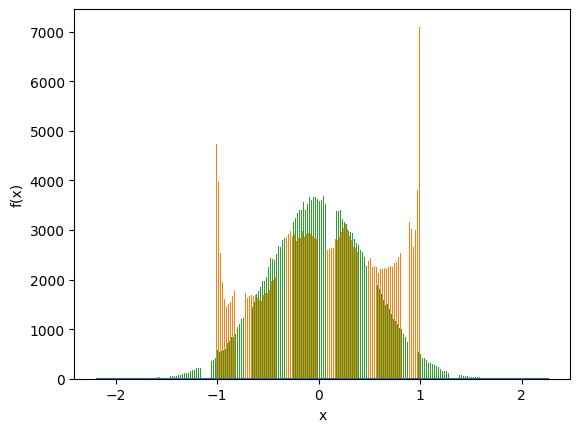

In [21]:
gaussian_reservoir_1.pre_train(X_TS, 0, 0)
gaussian_reservoir_1.predict(X_TS, save_gradients=False, save_states=True)
gaussian_reservoir_1.plot_neural_activity()

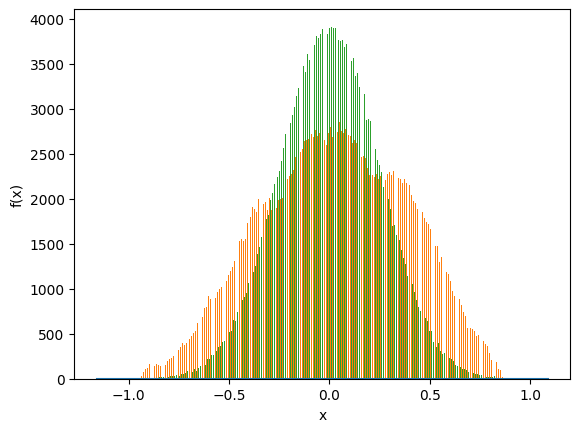

In [32]:
gaussian_reservoir_2.pre_train(X_TS, 0, 0)
gaussian_reservoir_2.predict(X_TS, save_gradients=False, save_states=True)
gaussian_reservoir_2.plot_neural_activity(apply_activation_X=True)

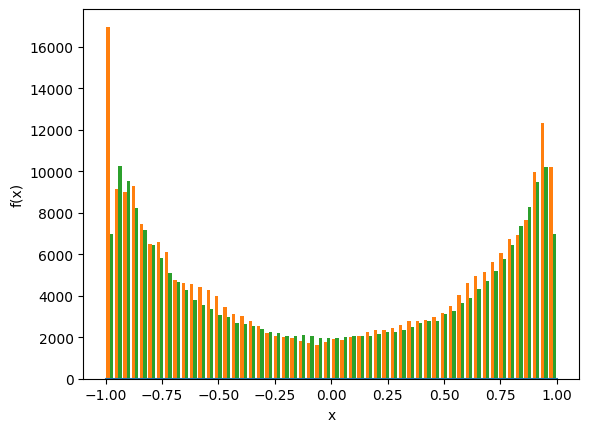

In [29]:
bimodal_reservoir.pre_train(X_TS, 0, 0)
bimodal_reservoir.predict(X_TS, save_gradients=False, save_states=True)
bimodal_reservoir.plot_neural_activity(apply_activation_Y=True)

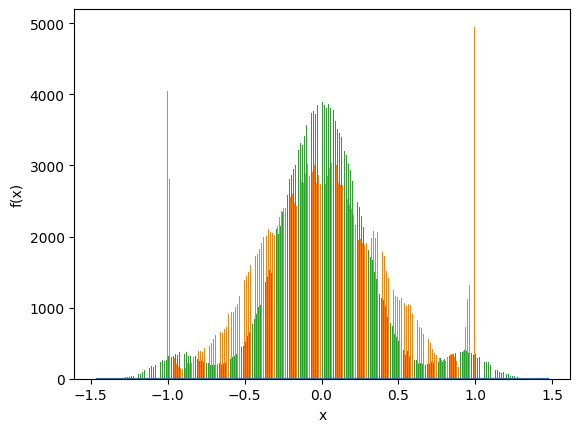

In [24]:
trimodal_reservoir_1.pre_train(X_TS, 0, 0)
trimodal_reservoir_1.predict(X_TS, save_gradients=False, save_states=True)
trimodal_reservoir_1.plot_neural_activity()

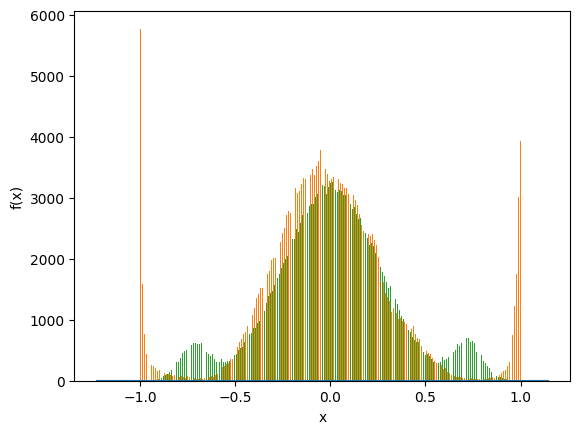

In [25]:
trimodal_reservoir_2.pre_train(X_TS, 0, 0)
trimodal_reservoir_2.predict(X_TS, save_gradients=False, save_states=True)
trimodal_reservoir_2.plot_neural_activity()

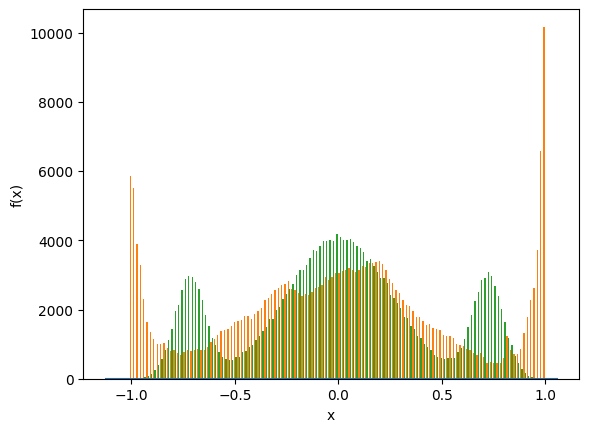

In [26]:
trimodal_reservoir_3.pre_train(X_TS, 0, 0)
trimodal_reservoir_3.predict(X_TS, save_gradients=False, save_states=True)
trimodal_reservoir_3.plot_neural_activity()